<a href="https://colab.research.google.com/github/sam916060/PhD_Thesis/blob/main/copy_of_pinns_without_optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
19/19 [==============================] - 1s 8ms/step - loss: 0.4670 - val_loss: 0.2545
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.1449 - val_loss: 0.1475
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.1070 - val_loss: 0.1191
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0957 - val_loss: 0.1164
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0914 - val_loss: 0.1089
Epoch 6/100
19/19 [==============================] - 0s 2ms/step - loss: 0.0884 - val_loss: 0.1056
Epoch 7/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0869 - val_loss: 0.1021
Epoch 8/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0853 - val_loss: 0.0998
Epoch 9/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0845 - val_loss: 0.0981
Epoch 10/100
19/19 [==============================] - 0s 3ms/step - loss: 0.0842 - val_loss: 0.0972
Epoch 11/

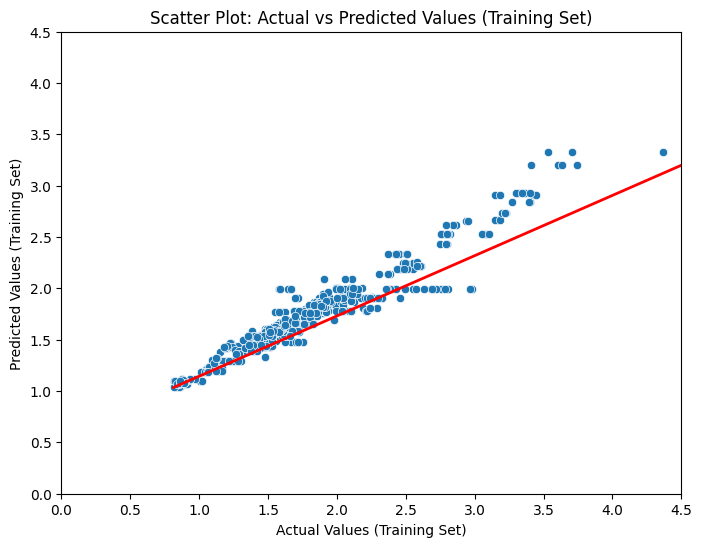

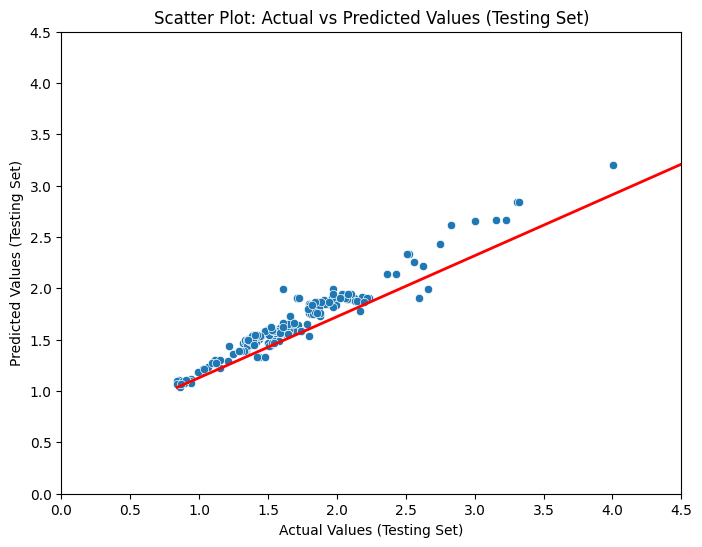

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seeds for reproducibility
seed_value = 11
tf.random.set_seed(seed_value)
np.random.seed(seed_value)


# Load the dataset
dataset = pd.read_csv("IRI_11-07.csv")

# Split the dataset into features (X) and target (y)
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# Feature Scaling for training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Define the Huber loss function for the physics term
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    abs_error = tf.abs(error)
    quadratic_part = tf.minimum(abs_error, delta)
    linear_part = abs_error - quadratic_part
    return tf.reduce_mean(0.5 * tf.square(quadratic_part) + delta * linear_part)

# Define the loss function
def loss_fn(y_true, y_pred):
    # Data-driven term (Huber loss)
    delta = 1.0
    data_loss = tf.reduce_mean(tf.where(tf.abs(y_true - y_pred) <= delta,
                                        0.5 * tf.square(y_true - y_pred),
                                        delta * tf.abs(y_true - y_pred) - 0.5 * tf.square(delta)))

    # Physics-driven term (using the unscaled data)
    IRI1 = X_train[:, 0]
    CRK = X_train[:, 1]
    SPALL = X_train[:, 2]
    FAULT = X_train[:, 4]
    AGE = X_train[:, 5]
    FI = X_train[:, 6]
    P200 = X_train[:, 7]
    PATCH = X_train[:, 3]

    physics_loss = huber_loss(y_pred,
                              IRI1 + 0.013 * CRK + 0.007 * SPALL + 0.005 * PATCH + 0.0015 * FAULT +
                              0.45 * ((AGE * (1 + FI)) * (1 + P200) / 1000000),
                              delta=1.0)  # You can adjust the delta value here

    # Combine the data-driven and physics-driven terms
    loss = 0.75*data_loss + 0.25* physics_loss

    return loss

# Compile and train the PINN model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=loss_fn)

# Use verbose=1 to print losses with epochs
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Predict with the trained model
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print(f"Training Set Metrics:")
print(f"Mean Absolute Error: {mae_train:.4f}")
print(f"Root Mean Square Error: {rmse_train:.4f}")
print(f"R2 Value: {r2_train:.4f}")

print(f"\nTesting Set Metrics:")
print(f"Mean Absolute Error: {mae_test:.4f}")
print(f"Root Mean Square Error: {rmse_test:.4f}")
print(f"R2 Value: {r2_test:.4f}")

# Scatter plot for predicted vs actual values (Training Set)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_train, y=y_train_pred.flatten())
plt.plot([min(y_train), max(y_train)], [min(y_train_pred.flatten()), max(y_train_pred.flatten())], 'r-', lw=2)
plt.xlabel("Actual Values (Training Set)")
plt.ylabel("Predicted Values (Training Set)")

# Set desired axis ranges
plt.xlim(0, 4.5)
plt.ylim(0, 4.5)

plt.title("Scatter Plot: Actual vs Predicted Values (Training Set)")
plt.show()

# Scatter plot for predicted vs actual values (Testing Set)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred.flatten())
plt.plot([min(y_test), max(y_test)], [min(y_test_pred.flatten()), max(y_test_pred.flatten())], 'r-', lw=2)
plt.xlabel("Actual Values (Testing Set)")
plt.ylabel("Predicted Values (Testing Set)")

# Set desired axis ranges
plt.xlim(0, 4.5)
plt.ylim(0, 4.5)

plt.title("Scatter Plot: Actual vs Predicted Values (Testing Set)")
plt.show()


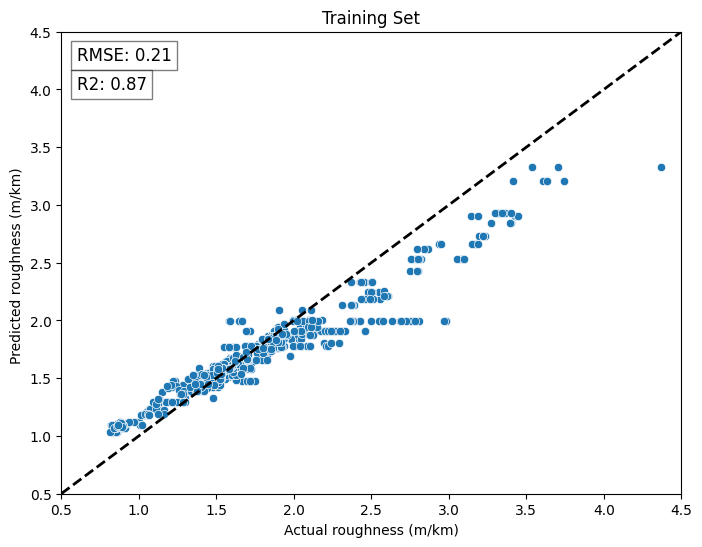

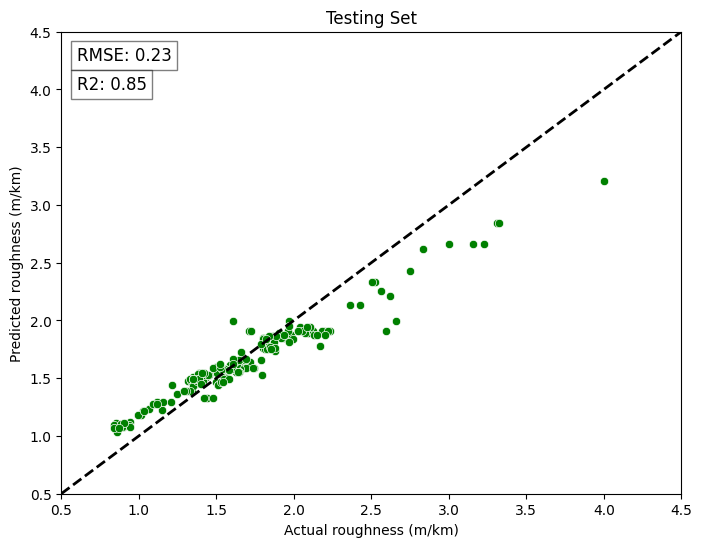

In [ ]:
# Scatter plot for predicted vs actual values (Training Set)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_train, y=y_train_pred.flatten())
plt.plot([0.5, 4.5], [0.5, 4.5], 'k--', lw=2)
plt.xlabel("Actual roughness (m/km)")
plt.ylabel("Predicted roughness (m/km) ")

# Set desired axis ranges
plt.xlim(0.5, 4.5)
plt.ylim(0.5, 4.5)

# Calculate RMSE and R2 for the training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

# Add RMSE and R2 values inside the plot
plt.text(0.6, 4.25, f"RMSE: {rmse_train:.2f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.6, 4, f"R2: {r2_train:.2f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.title("Training Set")
plt.show()

# Scatter plot for predicted vs actual values (Testing Set)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred.flatten(), color = 'g')
plt.plot([0.5, 4.5], [0.5, 4.5], 'k--', lw=2)
plt.xlabel("Actual roughness (m/km)")
plt.ylabel("Predicted roughness (m/km)")

# Set desired axis ranges
plt.xlim(0.5, 4.5)
plt.ylim(0.5, 4.5)

# Calculate RMSE and R2 for the testing set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

# Add RMSE and R2 values inside the plot
plt.text(0.6, 4.25, f"RMSE: {rmse_test:.2f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.6, 4, f"R2: {r2_test:.2f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.title("Testing Set")
plt.show()

Epoch 1/100
19/19 [==============================] - 3s 24ms/step - loss: 0.0857 - val_loss: 0.0952
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0842 - val_loss: 0.0925
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0840 - val_loss: 0.0891
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0840 - val_loss: 0.0911
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0839 - val_loss: 0.0915
Epoch 6/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0828 - val_loss: 0.0922
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0820 - val_loss: 0.0898
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0827 - val_loss: 0.0911
Epoch 9/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0825 - val_loss: 0.0906
Epoch 10/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0826 - val_loss: 0.0930
Epoch 11

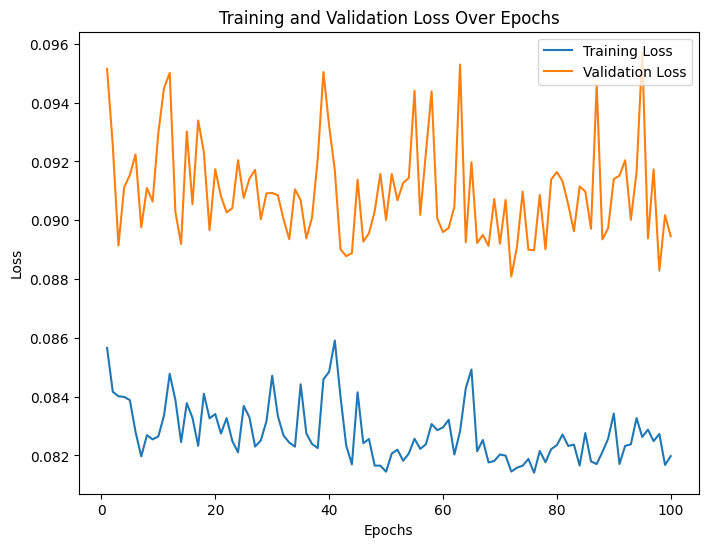

In [ ]:
# Compile and train the PINN model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=loss_fn)

# Use verbose=1 to print losses with epochs and record the training history
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Extract the loss values from the history
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Plot the epochs vs. loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

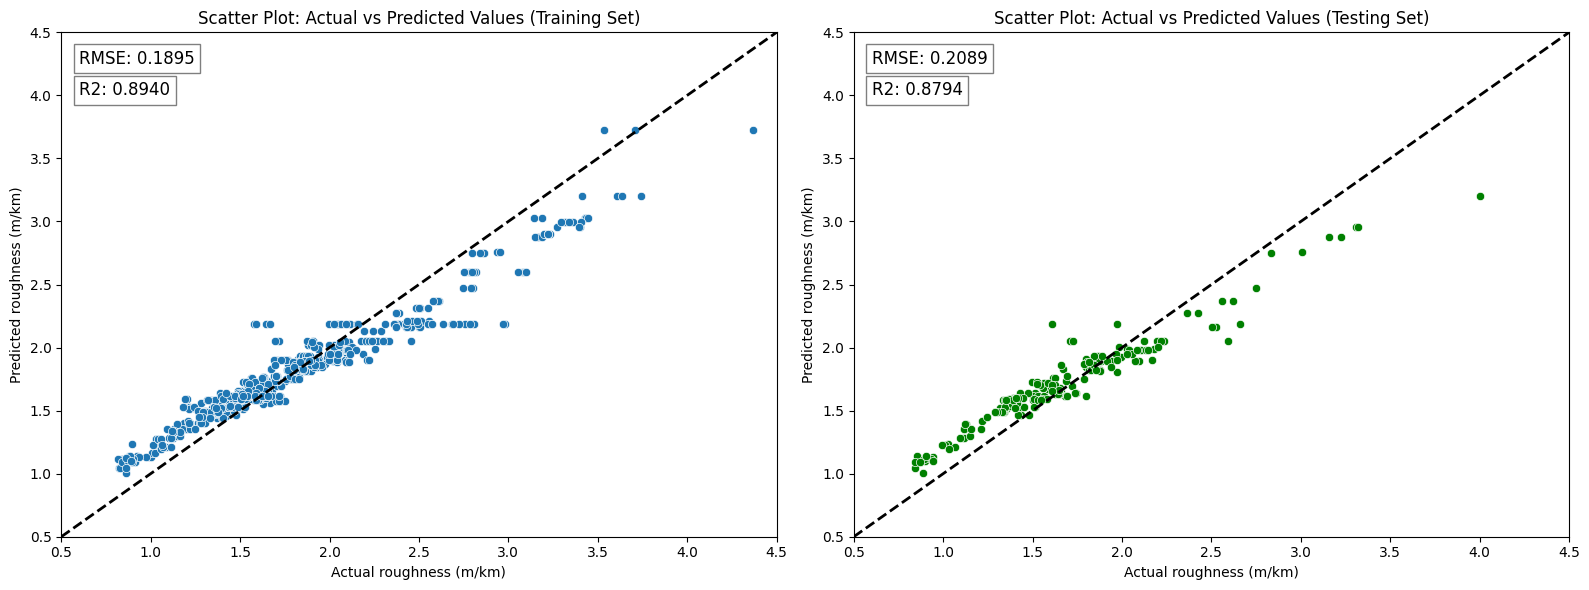

In [ ]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot for predicted vs actual values (Training Set)
sns.scatterplot(x=y_train, y=y_train_pred.flatten(), ax=axes[0])
axes[0].plot([0.5, 4.5], [0.5, 4.5], 'k--', lw=2)
axes[0].set_xlabel("Actual roughness (m/km)")
axes[0].set_ylabel("Predicted roughness (m/km)")
axes[0].set_xlim(0.5, 4.5)
axes[0].set_ylim(0.5, 4.5)

# Calculate RMSE and R2 for the training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

# Add RMSE and R2 values inside the plot
axes[0].text(0.6, 4.25, f"RMSE: {rmse_train:.4f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
axes[0].text(0.6, 4, f"R2: {r2_train:.4f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

axes[0].set_title("Scatter Plot: Actual vs Predicted Values (Training Set)")

# Scatter plot for predicted vs actual values (Testing Set)
sns.scatterplot(x=y_test, y=y_test_pred.flatten(), color='g', ax=axes[1])
axes[1].plot([0.5, 4.5], [0.5, 4.5], 'k--', lw=2)
axes[1].set_xlabel("Actual roughness (m/km)")
axes[1].set_ylabel("Predicted roughness (m/km)")
axes[1].set_xlim(0.5, 4.5)
axes[1].set_ylim(0.5, 4.5)

# Calculate RMSE and R2 for the testing set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

# Add RMSE and R2 values inside the plot
axes[1].text(0.6, 4.25, f"RMSE: {rmse_test:.4f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
axes[1].text(0.6, 4, f"R2: {r2_test:.4f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

axes[1].set_title("Scatter Plot: Actual vs Predicted Values (Testing Set)")

# Adjust the layout to prevent overlap of titles
plt.tight_layout()
plt.show()


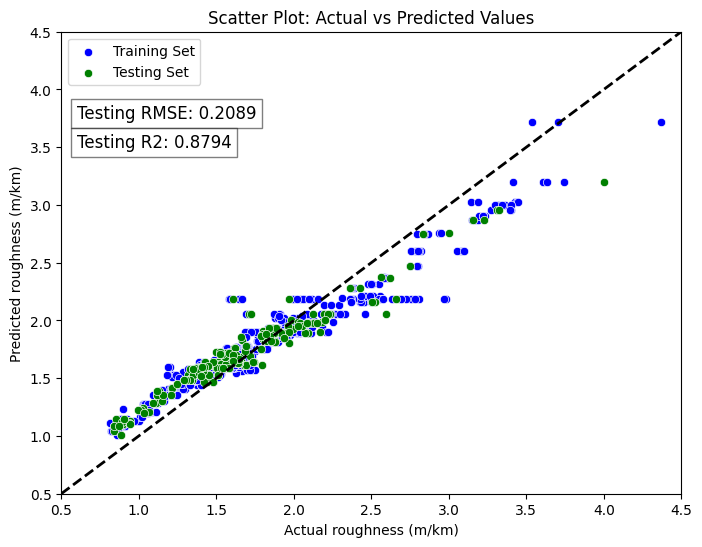

In [ ]:
# Scatter plot for predicted vs actual values (Training Set)
plt.figure(figsize=(8, 6))

# Training set
sns.scatterplot(x=y_train, y=y_train_pred.flatten(), label='Training Set', color='b')

# Testing set
sns.scatterplot(x=y_test, y=y_test_pred.flatten(), label='Testing Set', color='g')

# Plot the 1:1 line
plt.plot([0.5, 4.5], [0.5, 4.5], 'k--', lw=2)

plt.xlabel("Actual roughness (m/km)")
plt.ylabel("Predicted roughness (m/km)")

# Set desired axis ranges
plt.xlim(0.5, 4.5)
plt.ylim(0.5, 4.5)

# Calculate RMSE and R2 for the training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

# Calculate RMSE and R2 for the testing set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

# Add RMSE and R2 values inside the plot


plt.text(0.6, 3.75, f"Testing RMSE: {rmse_test:.4f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.6, 3.5, f"Testing R2: {r2_test:.4f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.title("Scatter Plot: Actual vs Predicted Values")
plt.legend()
plt.show()
